In [1]:
import pgmpy.models
import pgmpy.inference
import networkx as nx
import pylab as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv

from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination

In [2]:
# IMPORTING THE CLEAN DATA: 
my_data = pd.read_csv('/Users/farahayyad/Desktop/SLR-Research/New-Titanic/final_data.csv')
my_data

,Unnamed: 0,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,0,2,0,1.0,1,0,2.0
1,1,1,0,1,1.0,1,0,0.0
2,2,1,2,1,1.0,0,0,2.0
3,3,1,0,1,1.0,1,0,2.0
4,4,0,2,0,1.0,0,0,2.0
...,...,...,...,...,...,...,...,...
728,728,0,2,1,1.0,0,5,1.0
729,729,0,1,0,1.0,0,0,2.0
730,730,1,0,1,1.0,0,0,2.0
731,731,1,0,0,1.0,0,0,0.0


Removing Unused Columns

In [3]:
my_data.drop(my_data.columns[0], axis=1, inplace=True)
my_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,2,0,1.0,1,0,2.0
1,1,0,1,1.0,1,0,0.0
2,1,2,1,1.0,0,0,2.0
3,1,0,1,1.0,1,0,2.0
4,0,2,0,1.0,0,0,2.0
...,...,...,...,...,...,...,...
728,0,2,1,1.0,0,5,1.0
729,0,1,0,1.0,0,0,2.0
730,1,0,1,1.0,0,0,2.0
731,1,0,0,1.0,0,0,0.0


In [4]:
my_data = my_data.dropna()

# Creating the Model:

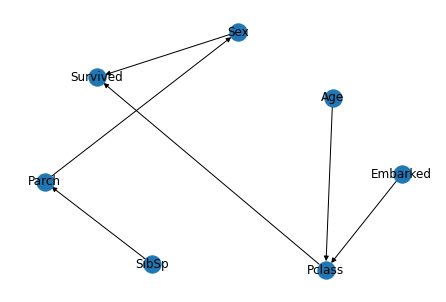

In [5]:
# create structure of BN model
model = BayesianModel([('SibSp', 'Parch'), ('Parch', 'Sex'),('Sex','Survived'),('Pclass','Survived'),('Age','Pclass'),('Embarked','Pclass')])
nx.draw(model, with_labels=True)

In [6]:
# Split Data Set:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(my_data, my_data, test_size=0.25)

In [7]:
# Train model on x_train dataset:
model.fit(x_train, estimator=BayesianEstimator, prior_type="BDeu")

In [8]:
# Variable Elimination and Posterior predictions, after associating all CPDs
infr = VariableElimination(model)
posterior_probability = infr.query(variables=['Survived'])
print(posterior_probability)

Eliminating: Sex: 100%|██████████| 6/6 [00:00<00:00, 128.70it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.5999 |
+-------------+-----------------+
| Survived(1) |          0.4001 |
+-------------+-----------------+


In [9]:
# Test on x_test:
predict_data = x_test.drop(columns=['Survived'], axis=1)
y_pred = model.predict(predict_data)

100%|██████████| 73/73 [00:03<00:00, 21.82it/s]


In [10]:
# Compare train to predictions
import sklearn
x = sklearn.metrics.accuracy_score(y_pred['Survived'], x_test['Survived'])
print(x)

0.8033707865168539


# Data Visualizations:

In [11]:
def Survival(dataframe, field, value):
    count = 0
    for index, row in dataframe.iterrows():
        if field == 0 and value == 0:
            if row['Survived'] == 1:
                count += 1
        if row[field] == value and row['Survived'] == 1:
            count +=1
    return count

In [12]:
female_live = Survival(my_data, "Sex", 1)
male_live = Survival(my_data, "Sex", 0)
female_all = 0
male_all = 0

for index, row in my_data.iterrows():
    if row['Sex'] == 1:
        female_all +=1
    if row['Sex'] == 0:
        male_all +=1

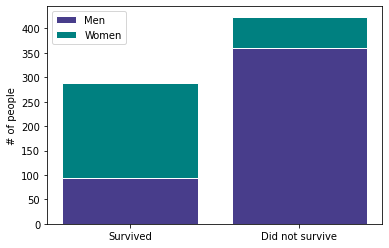

In [13]:
N = 2

female_die = female_all - female_live
male_die = male_all - male_live

women_data = (female_live, female_die)
men_data = (male_live, male_die)
ind = np.arange(N)    # the x locations for the groups

p1 = plt.bar(ind, men_data, facecolor='darkslateblue', edgecolor='white', align='center')
p2 = plt.bar(ind, women_data, facecolor='teal',edgecolor='white', bottom=men_data, align='center')

plt.ylabel('# of people')
plt.xticks(ind, ('Survived', 'Did not survive'))
plt.legend((p1[0], p2[0]), ('Men', 'Women'), loc="upper left")
plt.show()

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

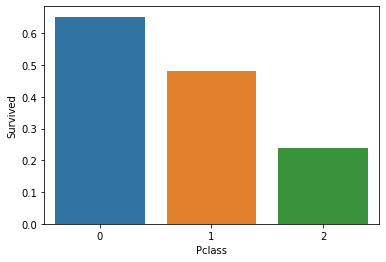

In [14]:
import seaborn as sns

pclass_surv_mean = my_data[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean()

# Plot the total number of passengers per class
fig, ax = plt.subplots()
sns.barplot(x="Pclass", y="Survived", data=pclass_surv_mean, label="Total number of passengers", order=[0,1,2], ax=ax)

<AxesSubplot:xlabel='Age', ylabel='Survived'>

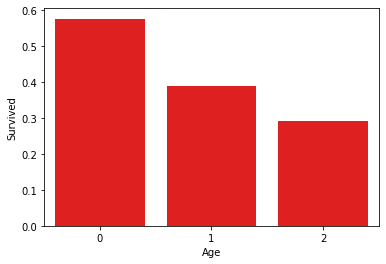

In [15]:
pclass_surv_mean = my_data[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()

# Plot the total number of passengers per class
fig, ax = plt.subplots()
sns.barplot(x="Age", y="Survived", data=pclass_surv_mean, label="Ages of Passengers", order=[0,1,2], ax=ax, color='red')

# Cross Validation:

# 1. Using Sklearn:

from sklearn import model_selection
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression

x = my_data.iloc[:,:-1]
y = my_data.iloc[:,-1]

k = 10
kf = model_selection.KFold(n_splits=k, random_state=None)

model = LogisticRegression(solver= 'liblinear')

result = cross_val_score(model , x, y, cv = kf, scoring="accuracy")

print(result)
print(result.mean())

# 2. User-defined functions:

In [16]:
def evaluate(md, dt, k):
    s_list = []
    
    for i in range (k):
        
        if(k==0):
            break
        elif(k==1):
            d_train, d_test = train_test_split(dt, test_size=1/2)
        else:
            d_train, d_test = train_test_split(dt, test_size=1/k)
            
        dt = d_train

        # Train model on the train dataset:
        md.fit(d_train, estimator=BayesianEstimator, prior_type="BDeu")
        
        # Test: (find predictions) using d_test:
        pred_data = d_test.drop(columns=['Survived'], axis=1)
        new_pred = md.predict(pred_data)
        
        # Validate Accuracy: Compare calculated predictions to actual values
        s = sklearn.metrics.accuracy_score(new_pred['Survived'], d_test['Survived'])
        s_list.append(s)
        k -= 1
        print(s_list)
        
    return s_list

In [17]:
s_list = evaluate(model, my_data, 10)

  0%|          | 0/38 [00:00<?, ?it/s]

[0.9027777777777778]


  0%|          | 0/40 [00:00<?, ?it/s]

[0.9027777777777778, 0.7638888888888888]


  0%|          | 0/39 [00:00<?, ?it/s]

[0.9027777777777778, 0.7638888888888888, 0.7746478873239436]


  0%|          | 0/43 [00:00<?, ?it/s]

[0.9027777777777778, 0.7638888888888888, 0.7746478873239436, 0.7746478873239436]


  0%|          | 0/38 [00:00<?, ?it/s]

[0.9027777777777778, 0.7638888888888888, 0.7746478873239436, 0.7746478873239436, 0.7183098591549296]


  0%|          | 0/36 [00:00<?, ?it/s]

[0.9027777777777778, 0.7638888888888888, 0.7746478873239436, 0.7746478873239436, 0.7183098591549296, 0.8028169014084507]


100%|██████████| 36/36 [00:00<00:00, 232.53it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices